In [138]:
import os
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms
import mlflow
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob
import torch.optim as optim


In [139]:

def create_center_mask(image_size, max_percentage=10):
    """
    Create a mask with a black square in the center for the region to inpaint.

    Args:
        image_size (tuple): (width, height) of the image.
        max_percentage (float): Maximum percentage of the image area covered by the square.

    Returns:
        Image: Binary mask where 1 (or 255) represents the inpainting region.
    """
    width, height = image_size
    max_area = (width * height) * (max_percentage / 100)  # Maximum area of the square
    side_length = int(max_area ** 0.5)

    # Create an empty mask
    mask = Image.new("L", (width, height), 0)  # Binary mask (0 for background)
    draw = ImageDraw.Draw(mask)

    # Define the square's position
    x0 = (width - side_length) // 2
    y0 = (height - side_length) // 2
    x1 = x0 + side_length
    y1 = y0 + side_length

    # Draw the inpainting region as white (255)
    draw.rectangle([x0, y0, x1, y1], fill=255)

    return mask

# Example: Create a mask
image_size = (224, 224)  # Replace with your image size
mask = create_center_mask(image_size, max_percentage=10)
# mask.show()  # Visualize the mask


In [140]:
# # Paths to the dataset
# base_path = "Data"
# vegetable_images_path = os.path.join(base_path, "VegetableImages")
# holed_images_path = os.path.join(base_path, "HoledImages")
# output_normalized_path = "NormalizedData"
# output_augmented_path = "AugmentedData"

# Transformations
normalize_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor with values in [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# # Function to process images
# def preprocess_images(input_path, output_path, transform, process_type="normalization"):
#     for root, _, files in os.walk(input_path):
#         for file in files:
#             if file.endswith(('.png', '.jpg', '.jpeg')):  # Add supported image formats
#                 img_path = os.path.join(root, file)
#                 img = Image.open(img_path).convert("RGB")
#                 processed_img = transform(img)
                
#                 # Convert tensor to numpy array for saving
#                 np_img = processed_img.numpy().transpose(1, 2, 0)
                
#                 # Save image in the corresponding output folder
#                 save_path = os.path.join(output_path, os.path.relpath(img_path, input_path))
#                 os.makedirs(os.path.dirname(save_path), exist_ok=True)
#                 Image.fromarray((np_img * 255).astype('uint8')).save(save_path)
#                 print(f"{process_type.capitalize()} processed: {save_path}")

# # MLflow Integration
# mlflow.set_experiment("Image Inpainting Preprocessing")

# with mlflow.start_run(run_name="Preprocessing") as run:
#     start_time = time.time()
    
#     # Log parameters for normalization and augmentation
#     mlflow.log_param("Normalization", "[-1, 1]")
#     mlflow.log_param("Augmentation", "RandomHorizontalFlip, RandomRotation, ColorJitter")
    
#     # Normalize VegetableImages
#     print("Normalizing VegetableImages...")
#     preprocess_images(vegetable_images_path, os.path.join(output_normalized_path, "VegetableImages"), normalize_transform, process_type="normalization")
#     mlflow.log_artifacts(os.path.join(output_normalized_path, "VegetableImages"), artifact_path="NormalizedVegetableImages")

#     # Normalize HoledImages
#     print("Normalizing HoledImages...")
#     preprocess_images(holed_images_path, os.path.join(output_normalized_path, "HoledImages"), normalize_transform, process_type="normalization")
#     mlflow.log_artifacts(os.path.join(output_normalized_path, "HoledImages"), artifact_path="NormalizedHoledImages")
    
#     # Augment VegetableImages
#     print("Augmenting VegetableImages...")
#     preprocess_images(vegetable_images_path, os.path.join(output_augmented_path, "VegetableImages"), augmentation_transforms, process_type="augmentation")
#     mlflow.log_artifacts(os.path.join(output_augmented_path, "VegetableImages"), artifact_path="AugmentedVegetableImages")

#     # Augment HoledImages
#     print("Augmenting HoledImages...")
#     preprocess_images(holed_images_path, os.path.join(output_augmented_path, "HoledImages"), augmentation_transforms, process_type="augmentation")
#     mlflow.log_artifacts(os.path.join(output_augmented_path, "HoledImages"), artifact_path="AugmentedHoledImages")
    
#     # Log time taken for preprocessing
#     total_time = time.time() - start_time
#     mlflow.log_metric("Preprocessing Time (seconds)", total_time)
#     print(f"Preprocessing completed in {total_time:.2f} seconds.")

In [141]:
class InpaintingModel(nn.Module):
    def __init__(self):
        super(InpaintingModel, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # Input includes mask (4 channels)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  # Output: (B, 512, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: (B, 256, 28, 28)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (B, 128, 56, 56)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (B, 64, 112, 112)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # Output: (B, 3, 224, 224)
            nn.Tanh()  # Pixel values in [-1, 1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        bottleneck = self.bottleneck(encoded)
        decoded = self.decoder(bottleneck)
        return decoded

# Instantiate the model
model = InpaintingModel()
print(model)

InpaintingModel(
  (encoder): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4

In [142]:
from torchvision.transforms import ToTensor

def combine_image_and_mask(image, mask):
    """
    Combine an image and its mask into a 4-channel input.

    Args:
        image (PIL.Image): The input image.
        mask (PIL.Image): The binary mask.

    Returns:
        Tensor: 4-channel tensor (image + mask).
    """
    image_tensor = ToTensor()(image)  # Convert image to tensor
    mask_tensor = ToTensor()(mask)  # Convert mask to tensor
    combined = torch.cat((image_tensor, mask_tensor), dim=0)  # Combine along channel dimension
    return combined





In [156]:
class InpaintingDataset(Dataset):
    def __init__(self, holed_dir, ground_truth_dir, mask, transform=None, limit=None):
        """
        Args:
            holed_dir (str): Path to the directory with holed images (e.g., HoledImages/train).
            ground_truth_dir (str): Path to the directory with ground truth images (e.g., VegetableImages/train).
            mask (PIL.Image): Precomputed binary mask for the inpainting region.
            transform (callable, optional): Optional transform to apply to the images.
            limit (int, optional): Limit the number of images used.
        """
        self.holed_paths = sorted(glob.glob(os.path.join(holed_dir, "**", "*.*"), recursive=True))
        self.ground_truth_paths = sorted(glob.glob(os.path.join(ground_truth_dir, "**", "*.*"), recursive=True))
        self.mask = transforms.ToTensor()(mask)  # Convert mask to a tensor
        self.transform = transform

        # Ensure paths match and limit dataset size if needed
        assert len(self.holed_paths) == len(self.ground_truth_paths), "Mismatch between holed and ground truth images"
        if limit:
            self.holed_paths = self.holed_paths[:limit]
            self.ground_truth_paths = self.ground_truth_paths[:limit]

    def __len__(self):
        return len(self.holed_paths)

    def __getitem__(self, idx):
        # Load the holed and ground truth images
        holed_path = self.holed_paths[idx]
        ground_truth_path = self.ground_truth_paths[idx]

        holed_image = Image.open(holed_path).convert("RGB")
        ground_truth_image = Image.open(ground_truth_path).convert("RGB")

        # Apply transforms if provided
        if self.transform:
            holed_image = self.transform(holed_image)
            ground_truth_image = self.transform(ground_truth_image)

        # Ensure the mask has the same spatial dimensions as the image
        mask_tensor = self.mask
        if mask_tensor.shape[-2:] != holed_image.shape[-2:]:
            mask_tensor = torch.nn.functional.interpolate(
                mask_tensor.unsqueeze(0), size=holed_image.shape[-2:]
            ).squeeze(0)

        # Create 4-channel input (holed image + mask)
        combined_input = torch.cat((holed_image, mask_tensor), dim=0)

        return combined_input, ground_truth_image


# Example usage
mask = create_center_mask((224, 224), max_percentage=10)
mask = create_center_mask((224, 224), max_percentage=10)

train_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/train",
    ground_truth_dir="NormalizedData/VegetableImages/train",
    mask=mask,
    transform=normalize_transform,
    limit=1000  # Use only 1000 images
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Check the data
for combined_input, target in train_loader:
    print(f"Input shape: {combined_input.shape}, Target shape: {target.shape}")
    break


Input shape: torch.Size([16, 4, 224, 224]), Target shape: torch.Size([16, 3, 224, 224])


In [144]:
loss_fn = nn.MSELoss()  # Pixel-wise MSE loss


In [145]:
def masked_loss(output, target, mask):
    """
    Compute MSE loss only for the masked region.

    Args:
        output (Tensor): Model output (B, C, H, W).
        target (Tensor): Ground truth image (B, C, H, W).
        mask (Tensor): Binary mask indicating the region to inpaint (B, 1, H, W).

    Returns:
        Tensor: Loss value.
    """
    mask = mask.to(output.device)  # Ensure mask is on the same device
    loss = ((output - target) ** 2) * mask  # Apply the mask
    return loss.sum() / mask.sum()  # Normalize by the number of pixels in the mask


In [146]:
# # Initialize model, optimizer, and device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = InpaintingModel().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0

#     for combined_input, target in train_loader:
#         combined_input, target = combined_input.to(device), target.to(device)
        
#         # Forward pass
#         output = model(combined_input)
#         loss = loss_fn(output, target)
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


In [147]:
# # Validation Dataset (optional)
# val_dataset = InpaintingDataset(
#     holed_dir="NormalizedData/HoledImages/val",
#     ground_truth_dir="NormalizedData/VegetableImages/val",
#     mask=mask,
#     transform=normalize_transform
# )
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# with mlflow.start_run(run_name="Inpainting Training"):
#     mlflow.log_param("Learning Rate", 1e-3)
#     mlflow.log_param("Batch Size", 32)
#     mlflow.log_param("Dataset Size", len(train_dataset))

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0.0

#         # Training
#         for combined_input, target in train_loader:
#             combined_input, target = combined_input.to(device), target.to(device)
            
#             # Forward pass
#             output = model(combined_input)
#             loss = loss_fn(output, target)
            
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()

#         avg_loss = total_loss / len(train_loader)
#         mlflow.log_metric("Train Loss", avg_loss, step=epoch)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")

#         # Validation (optional)
#         if val_loader:
#             model.eval()
#             val_loss = 0.0
#             with torch.no_grad():
#                 for combined_input, target in val_loader:
#                     combined_input, target = combined_input.to(device), target.to(device)
#                     output = model(combined_input)
#                     val_loss += loss_fn(output, target).item()
#             avg_val_loss = val_loss / len(val_loader)
#             mlflow.log_metric("Validation Loss", avg_val_loss, step=epoch)
#             print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

#     # Save the model
#     mlflow.pytorch.log_model(model, "InpaintingModel")


In [148]:
# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InpaintingModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  # Pixel-wise MSE loss

# Training Parameters
num_epochs = 50

# Validation Dataset (optional)
val_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/val",
    ground_truth_dir="NormalizedData/VegetableImages/val",
    mask=mask,
    transform=normalize_transform
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training with MLflow Logging
with mlflow.start_run(run_name="Inpainting Training"):
    # Log parameters
    mlflow.log_param("Learning Rate", 1e-3)
    mlflow.log_param("Batch Size", 32)
    mlflow.log_param("Dataset Size", len(train_dataset))

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_loss = 0.0

        for combined_input, target in train_loader:
            combined_input, target = combined_input.to(device), target.to(device)

            mask = combined_input[:, 3:4, :, :]
            
            # Forward pass
            output = model(combined_input)
            loss = masked_loss(output, target, mask)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        mlflow.log_metric("Train Loss", avg_loss, step=epoch)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")

        # Validation Phase (optional)
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for combined_input, target in val_loader:
                    combined_input, target = combined_input.to(device), target.to(device)
                    output = model(combined_input)
                    val_loss += loss_fn(output, target).item()
            avg_val_loss = val_loss / len(val_loader)
            mlflow.log_metric("Validation Loss", avg_val_loss, step=epoch)
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

    # Save the trained model
    mlflow.pytorch.log_model(model, "InpaintingModel")


Epoch [1/50], Train Loss: 0.7270
Epoch [2/50], Train Loss: 0.6993
Epoch [3/50], Train Loss: 0.6888
Epoch [4/50], Train Loss: 0.6756
Epoch [5/50], Train Loss: 0.6670
Epoch [6/50], Train Loss: 0.6616
Epoch [7/50], Train Loss: 0.6448
Epoch [8/50], Train Loss: 0.6252
Epoch [9/50], Train Loss: 0.6132
Epoch [10/50], Train Loss: 0.5948
Epoch [11/50], Train Loss: 0.5780
Epoch [12/50], Train Loss: 0.5610
Epoch [13/50], Train Loss: 0.5429
Epoch [14/50], Train Loss: 0.5184
Epoch [15/50], Train Loss: 0.4976
Epoch [16/50], Train Loss: 0.4738
Epoch [17/50], Train Loss: 0.4552
Epoch [18/50], Train Loss: 0.4356
Epoch [19/50], Train Loss: 0.4185
Epoch [20/50], Train Loss: 0.4013
Epoch [21/50], Train Loss: 0.3824
Epoch [22/50], Train Loss: 0.3662
Epoch [23/50], Train Loss: 0.3552
Epoch [24/50], Train Loss: 0.3459
Epoch [25/50], Train Loss: 0.3372
Epoch [26/50], Train Loss: 0.3268
Epoch [27/50], Train Loss: 0.3201
Epoch [28/50], Train Loss: 0.3108
Epoch [29/50], Train Loss: 0.2991
Epoch [30/50], Train Lo

2025/01/27 15:38:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.2+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.1.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/27 15:38:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.2+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.1.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/27 15:38:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [149]:
def denormalize(tensor, mean, std):
    """
    Undo normalization for visualization.
    Args:
        tensor (Tensor): Normalized tensor with shape (C, H, W).
        mean (list): Mean used for normalization (per channel).
        std (list): Standard deviation used for normalization (per channel).
    Returns:
        Tensor: Denormalized tensor.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize each channel
    return tensor


In [150]:
mean = [0.5, 0.5, 0.5]  # Replace with your normalization mean
std = [0.5, 0.5, 0.5]   # Replace with your normalization std


In [158]:
# Visualization with test images
def visualize_inpainting(test_loader, model, mean, std):
    model.eval()
    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            output = model(combined_input)

            # Extract mask and input image
            input_image = combined_input[:, :3, :, :].cpu()  # Input image (without mask)
            mask = combined_input[:, 3:4, :, :].cpu()  # Mask channel
            target_image = target.cpu()  # Ground truth
            output_image = output.cpu()  # Inpainted output

            # Denormalize images for visualization
            input_image = denormalize(input_image[0], mean, std).clamp(0, 1).permute(1, 2, 0).numpy()
            target_image = denormalize(target_image[0], mean, std).clamp(0, 1).permute(1, 2, 0).numpy()
            output_image = denormalize(output_image[0], mean, std).clamp(0, 1).permute(1, 2, 0).numpy()

            # Combine inpainted region with the input image
            inpainted_image = input_image.copy()
            mask_numpy = mask[0, 0].numpy()  # Convert mask to numpy
            inpainted_image[mask_numpy > 0] = output_image[mask_numpy > 0]

            # Visualize
            import matplotlib.pyplot as plt
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input (Holed)")
            plt.imshow(input_image)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(target_image)
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Inpainted Output")
            plt.imshow(inpainted_image)
            plt.axis("off")
            plt.show()
            break


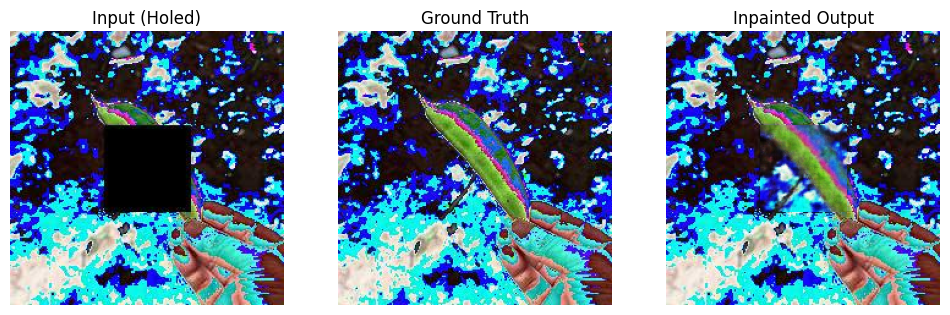

In [161]:
# Test the model on one image
test_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/test",
    ground_truth_dir="NormalizedData/VegetableImages/test",
    mask=mask,
    transform=normalize_transform,
    limit=10  # Use only 1 image
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Visualize the results
visualize_inpainting(test_loader, model, mean, std)
